In [1]:
import os
import urllib
import cv2
import numpy as np
from pixellib.semantic import semantic_segmentation
from matplotlib import pyplot as plt
from PIL import Image

In [2]:
os.getcwd()

'/aiffel/aiffel/human_segmentation/images'

In [4]:
# aiffel 이 두번 겹친다. images 파일 안에 저장되어있는 사진을 불러와야하ㅏ므로
# 상대 경로 설정 (현재 위치 기준)
my_image_path = '../images/Sungnyung.jpg' # 하나 위로 나가서 iamges로 들어가 지정
output_path = '../images/Sungnyung.png' # png로 나오게 


# 있으면 
if os.path.exists(my_image_path):
    # JPG 열어라
    image = Image.open(my_image_path)
    
    # JPG -> PNG로 변환 저장
    image.save(output_path)
    print(f"Image convert & Save success at {output_path}")
else:
    print(f"X: {os.path.abspath(my_image_path)}")

X: /aiffel/aiffel/human_segmentation/images/Sungnyung.jpg


(1440, 933, 3)


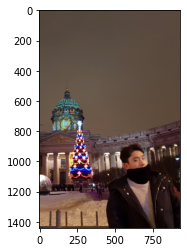

In [24]:
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/ME.png'  
img_orig = cv2.imread(img_path) 

print(img_orig.shape)

plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()

In [21]:
model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models' 
model_file = os.path.join(model_dir, 'deeplabv3_xception_tf_dim_ordering_tf_kernels.h5') 
model_url = 'https://github.com/ayoolaolafenwa/PixelLib/releases/download/1.1/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5' 

urllib.request.urlretrieve(model_url, model_file)

('/aiffel/aiffel/human_segmentation/models/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5',
 <http.client.HTTPMessage at 0x7d1e6426cf40>)

In [22]:
model = semantic_segmentation() # 객체 생성
model.load_pascalvoc_model(model_file) # file 내부 값의 가ㅣ중치 불러오기

In [25]:
segvalues, output = model.segmentAsPascalvoc(img_path) # pacalvoc 데이터로 학습된 모델이 입력된 이미지를 분할, 분할 출력의 배열까지 

In [23]:
#pascalvoc 데이터의 라벨종류
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)

21

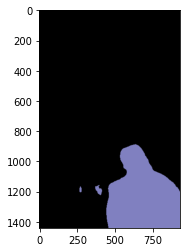

In [63]:
# 분할되어 나온 결과값 중 output을 matplotlib을 이용해 출력
plt.imshow(output)
plt.show()

* 위 사진에는 나말고도 뒤에 또다른 사람들이 찍혔다.
* 사진 상에서는 아주 작은데 해당 모델이 이를 사람으로 인식해서 뽑아낸 모습이다.

In [64]:
segvalues # 배열 출력 15번 인간

{'class_ids': array([ 0, 15]),
 'masks': array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ...,  True,  True,  True],
        [False, False, False, ...,  True,  True,  True],
        [False, False, False, ...,  True,  True,  True]])}

In [65]:
# 라벨 출력
for class_id in segvalues['class_ids']:
    print(LABEL_NAMES[class_id])

background
person


### 문제점
* 배경과 사람 둘 뿐. 아주 작음에도 사람으로 인식한 것은 모델의 성능이 믿을만 하다는 뜻

In [66]:
#컬러맵 만들기 
colormap = np.zeros((256, 3), dtype = int)
ind = np.arange(256, dtype=int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

colormap[:20] #생성한 20개의 컬러맵 출력

array([[  0,   0,   0],
       [128,   0,   0],
       [  0, 128,   0],
       [128, 128,   0],
       [  0,   0, 128],
       [128,   0, 128],
       [  0, 128, 128],
       [128, 128, 128],
       [ 64,   0,   0],
       [192,   0,   0],
       [ 64, 128,   0],
       [192, 128,   0],
       [ 64,   0, 128],
       [192,   0, 128],
       [ 64, 128, 128],
       [192, 128, 128],
       [  0,  64,   0],
       [128,  64,   0],
       [  0, 192,   0],
       [128, 192,   0]])

In [67]:
colormap[15] # 컬러맵 15번 : 인간 

array([192, 128, 128])

In [68]:
seg_color = (128,128,192) # 색상순서 변경 - colormap의 배열은 RGB 순이며 output의 배열은 BGR 순서로 채널 배치가 되어 있어서

(1440, 933)


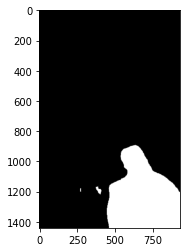

In [69]:
# output의 픽셀 별로 색상이 seg_color와 같다면 1(True), 다르다면 0(False)이 됩니다
# seg_color 값이 person을 값이 므로 사람이 있는 위치를 제외하고는 gray로 출력
# cmap 값을 변경하면 다른 색상으로 확인이 가능함
seg_map = np.all(output==seg_color, axis=-1) 
print(seg_map.shape) 
plt.imshow(seg_map, cmap='gray')
plt.show()

### 해결
* 조건 필터링 활용. 
* 특정 크기 이하의 넓이는 무시하는 컨투어 분석이 있다고 한다.

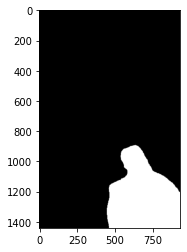

In [78]:
seg_map_binary = seg_map.astype(np.uint8)

# 컨투어 찾기 
# cv2.RETR_EXTERNAL : 외곽선만 찾음
# cv2.CHAIN_APPROX_SIMPLE : 컨투어를 찾을 때 외곽선의 점을 단순화(같은 직선 상의 점들은 모두 버림), 계산 속도 증가 및 메모리 절약 
# cv2.CHAIN_APPROX_NONE : 점들을 전부 저장
# 해당 함수는 2개의 값을 return하는데 아래와 같다. 
# contours: 각 컨투어의 좌표를 저장한 리스트.
# hierarchy : 계층구조 (도넛. 즉, 외곽선 안에 또다른 외곽선이 있을 때!) 여기서는 필요없음 
contours, _ = cv2.findContours(seg_map_binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# 새로운 seg_map 초기화 
filtered_seg_map = np.zeros_like(seg_map_binary) 

# 영역 크기 기반 필터링 
min_area = 900  # 최소 면적(넓이) 필터링 기준
for contour in contours:
    area = cv2.contourArea(contour)  # 컨투어 면적 계산
    if area > min_area: 
        cv2.drawContours(filtered_seg_map, [contour], -1, 1, thickness=cv2.FILLED)

# 조건 지정 후, 다시 논리형으로 (아래 mask에서 어짜피 다시 변환하기는 한다)
seg_map = filtered_seg_map.astype(bool) 

plt.imshow(seg_map, cmap='gray')
plt.show()

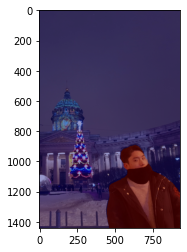

In [79]:
# 원본이미지를 img_show에 할당한뒤 이미지 사람이 있는 위치와 배경을 분리해서 표현한 color_mask 를 만든뒤 두 이미지를 합쳐서 출력
img_show = img_orig.copy()

# True과 False인 값을 각각 255과 0으로 바꿔줍니다
img_mask = seg_map.astype(np.uint8) * 255

# 255와 0을 적당한 색상으로 바꿔봅니다
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)

# 원본 이미지와 마스트를 적당히 합쳐봅니다
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.4, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

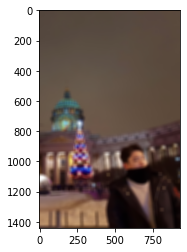

In [80]:
# (13,13)은 blurring kernel size를 뜻합니다
img_orig_blur = cv2.blur(img_orig, (25,25))

# plt.imshow(): 저장된 데이터를 이미지의 형식으로 표시한다.
# cv2.cvtColor(입력 이미지, 색상 변환 코드): 입력 이미지의 색상 채널을 변경
# cv2.COLOR_BGR2RGB: 원본이 BGR 순서로 픽셀을 읽다보니
# 이미지 색상 채널을 변경해야함 (BGR 형식을 RGB 형식으로 변경)   
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

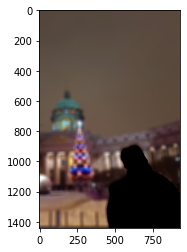

In [81]:
# cv2.cvtColor(입력 이미지, 색상 변환 코드): 입력 이미지의 색상 채널을 변경
# cv2.COLOR_BGR2RGB: 원본이 BGR 순서로 픽셀을 읽다보니
# 이미지 색상 채널을 변경해야함 (BGR 형식을 RGB 형식으로 변경) 
img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)

# cv2.bitwise_not(): 이미지가 반전됩니다. 배경이 0 사람이 255 였으나
# 연산을 하고 나면 배경은 255 사람은 0입니다.
img_bg_mask = cv2.bitwise_not(img_mask_color)

# cv2.bitwise_and()을 사용하면 배경만 있는 영상을 얻을 수 있습니다.
# 0과 어떤 수를 bitwise_and 연산을 해도 0이 되기 때문에 
# 사람이 0인 경우에는 사람이 있던 모든 픽셀이 0이 됩니다. 결국 사람이 사라지고 배경만 남아요!
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

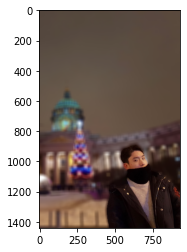

In [82]:
# np.where(조건, 참일때, 거짓일때)
# 세그멘테이션 마스크가 255인 부분만 원본 이미지 값을 가지고 오고 
# 아닌 영역은 블러된 이미지 값을 사용합니다.
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
# plt.imshow(): 저장된 데이터를 이미지의 형식으로 표시한다.
# cv2.cvtColor(입력 이미지, 색상 변환 코드): 입력 이미지의 색상 채널을 변경
# cv2.COLOR_BGR2RGB: 원본이 BGR 순서로 픽셀을 읽다보니 
# 이미지 색상 채널을 변경해야함 (BGR 형식을 RGB 형식으로 변경)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

### CAT&BIRD

(1440, 1080, 3)


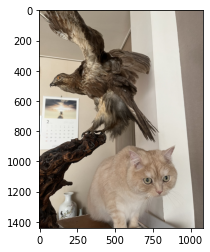

In [106]:
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/CAT_BIRD.png'  
img_orig = cv2.imread(img_path) 

print(img_orig.shape)

plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()

In [107]:
segvalues, output = model.segmentAsPascalvoc(img_path)

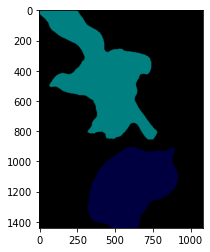

In [108]:
plt.imshow(output)
plt.show()

In [50]:
segvalues 

{'class_ids': array([0, 3, 8]),
 'masks': array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]])}

In [51]:
for class_id in segvalues['class_ids']:
    print(LABEL_NAMES[class_id])

background
bird
cat


In [52]:
#컬러맵 만들기 
colormap = np.zeros((256, 3), dtype = int)
ind = np.arange(256, dtype=int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

colormap[:20] 

array([[  0,   0,   0],
       [128,   0,   0],
       [  0, 128,   0],
       [128, 128,   0],
       [  0,   0, 128],
       [128,   0, 128],
       [  0, 128, 128],
       [128, 128, 128],
       [ 64,   0,   0],
       [192,   0,   0],
       [ 64, 128,   0],
       [192, 128,   0],
       [ 64,   0, 128],
       [192,   0, 128],
       [ 64, 128, 128],
       [192, 128, 128],
       [  0,  64,   0],
       [128,  64,   0],
       [  0, 192,   0],
       [128, 192,   0]])

In [53]:
colormap[3] 

array([128, 128,   0])

In [54]:
colormap[8] 

array([64,  0,  0])

In [44]:
output.shape

(1440, 1080, 3)

(1440, 1080)


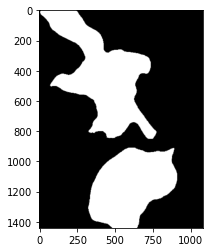

In [109]:
# 고양이와 새의 RGB 값. 각각 새랑 고양이인듯?
seg_colors = [
    [0, 128, 128],
    [0, 0, 64]
]

# seg_map 초기화 
seg_map = np.zeros(output.shape[:2], dtype=bool)

# 각 seg 조건 픽셀 박히게 
for seg_color in seg_colors:
    seg_map |= np.all(output == seg_color, axis=-1)  # 일치하면 True

print(seg_map.shape) 
plt.imshow(seg_map, cmap='gray') 
plt.show()

### 문제점
* 원본 사진과 비교하면, 다리 사이, 깃털 같은 미세한 픽셀들은 잘 잡아내지 못하는 모습이다.
* 이게 전처리의 문제일까, 모델의 문제일까
* 아마 둘 다 일 것이다.

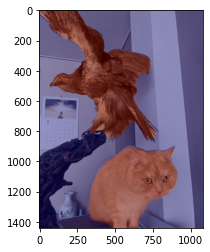

In [114]:
img_show = img_orig.copy()

img_mask = seg_map.astype(np.uint8) * 255

color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)

img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.4, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

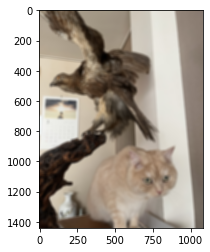

In [115]:
img_orig_blur = cv2.blur(img_orig, (20,20))

plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

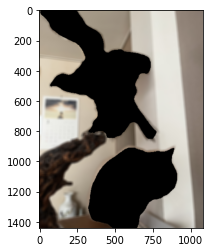

In [116]:
img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)

img_bg_mask = cv2.bitwise_not(img_mask_color)

img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

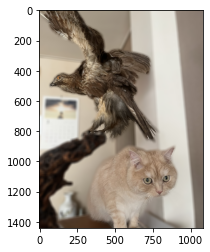

In [117]:
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)

plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

### 해결
* 아래 크로마키와 이어지는 전처리가 최대일 것 아니면, 모델 변경
* 블러링이라는 목적에서 세밀한 부분(엣지)을 보수적으로 잡을 필요가 있나?

### 크로마키 
* 제한사항

    1) 비슷한 색상의 화소값
    
    2) 역동적인 포즈
    
    3) 나쁜 화질 

(1239, 626, 3)


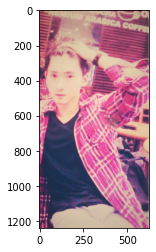

In [27]:
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/Leeds.png'  
img_orig = cv2.imread(img_path) 

print(img_orig.shape)

plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()

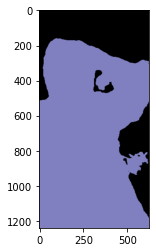

In [84]:
segvalues, output = model.segmentAsPascalvoc(img_path) 

plt.imshow(output)
plt.show()

* 이제 못 잡아내기 시작했다. 뭐가 문제일지 생각해보자 
* 일단은 사진 자체의 비슷한 색상이 문제일 가능성이 높다. 1차적으로 원본 사진에 노을빛 따위의 색상을 입혔으니까.
* 모델의 한계는 생각하지 말고 전처리를 통해 탐지 정확도를 높여보자.
* 탐지하려는 인물 경계를 따라 화소의 대비를 구분할 수 있게 해야한다.

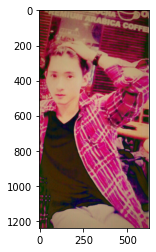

In [36]:
# 이미지 밝기 및 대비 조정
alpha = 1.3  # 대비 조정 (1.0 ~ 3.0)
beta = -100   # 밝기 조정 (-100 ~ 100)

adjusted_img = cv2.convertScaleAbs(img_orig, alpha=alpha, beta=beta)
plt.imshow(cv2.cvtColor(adjusted_img, cv2.COLOR_BGR2RGB))
plt.show()

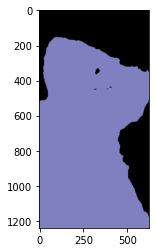

In [30]:
#전처리 시 넘파이 배열이 되어버려서 PIL 오류가 뜬다. 
import io

# numpy 배열을 PIL 이미지로 변환
pil_img = Image.fromarray(cv2.cvtColor(adjusted_img, cv2.COLOR_BGR2RGB))

# PIL 이미지를 BytesIO로 변환
img_byte_arr = io.BytesIO()
pil_img.save(img_byte_arr, format='JPEG')
img_byte_arr.seek(0)

# segmentAsPascalvoc에 BytesIO 객체 전달
segvalues, output = model.segmentAsPascalvoc(img_byte_arr)

# 결과 출력
plt.imshow(output)
plt.show()

* 조금은 좋아졌으나 아직까지 손 모션 안에 있는 귀나 얼굴형을 잘 잡아내지 못하고 있다.

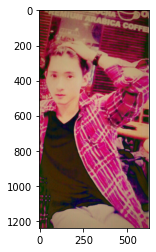

In [31]:
# 이미지 밝기 및 대비 조정
alpha = 1.3  # 대비 조정 (1.0 ~ 3.0)
beta = -100   # 밝기 조정 (-100 ~ 100)

adjusted_img = cv2.convertScaleAbs(img_orig, alpha=alpha, beta=beta)
plt.imshow(cv2.cvtColor(adjusted_img, cv2.COLOR_BGR2RGB))
plt.show()

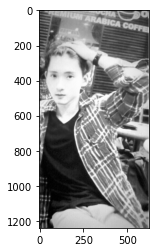

In [39]:
# 그레이스케일로 변환 후 히스토그램 평활화
gray = cv2.cvtColor(img_orig, cv2.COLOR_BGR2GRAY)
equalized_img = cv2.equalizeHist(gray)
plt.imshow(equalized_img)
plt.show()

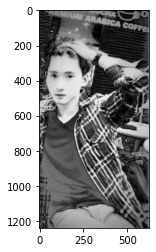

In [49]:
alpha = 1.4 
beta = -120 
adjusted_img = cv2.convertScaleAbs(equalized_img,alpha=alpha, beta=beta)
plt.imshow(adjusted_img)
plt.show()

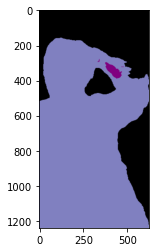

In [50]:
pil_img = Image.fromarray(cv2.cvtColor(equalized_img, cv2.COLOR_BGR2RGB))

img_byte_arr = io.BytesIO()
pil_img.save(img_byte_arr, format='JPEG')
img_byte_arr.seek(0)

segvalues, output = model.segmentAsPascalvoc(img_byte_arr)

plt.imshow(output)
plt.show()

In [43]:
for class_id in segvalues['class_ids']:
    print(LABEL_NAMES[class_id])

background
bottle
person


* 내 팔목을 bottle로 잡아내고 있다.

In [93]:
# 그레이스케일로 변환 후 히스토그램 평활화
gray = cv2.cvtColor(img_orig, cv2.COLOR_BGR2GRAY)
equalized_img = cv2.equalizeHist(gray)
equalized_img = cv2.cvtColor(equalized_img, cv2.COLOR_GRAY2BGR)

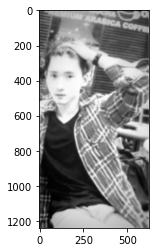

In [103]:
# 가우시안 블러링 적용
blurred_img = cv2.GaussianBlur(equalized_img, (15, 15), 0)

plt.imshow(cv2.cvtColor(blurred_img, cv2.COLOR_BGR2RGB))
plt.show()

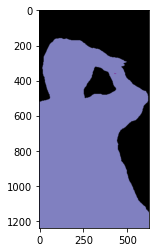

In [104]:
pil_img = Image.fromarray(cv2.cvtColor(blurred_img, cv2.COLOR_BGR2RGB))

img_byte_arr = io.BytesIO()
pil_img.save(img_byte_arr, format='JPEG')
img_byte_arr.seek(0)

segvalues, output = model.segmentAsPascalvoc(img_byte_arr)

plt.imshow(output)
plt.show()

* 블러링 커널 사이즈를 늘릴수록 팔목을 BOTTLE로 보는 경향은 사라지나, 내 팔목 자체를 탐지하지 못하는 문제가 발생한다.

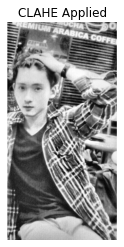

In [78]:
# CLAHE 적용
gray = cv2.cvtColor(img_orig, cv2.COLOR_BGR2GRAY)
clahe = cv2.createCLAHE(clipLimit=4.0, tileGridSize=(8, 8))
equalized_img = clahe.apply(gray)

# 결과 확인
plt.imshow(equalized_img, cmap='gray')
plt.title("CLAHE Applied")
plt.axis('off')
plt.show()

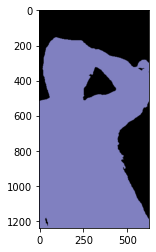

In [79]:
pil_img = Image.fromarray(cv2.cvtColor(equalized_img, cv2.COLOR_BGR2RGB))

img_byte_arr = io.BytesIO()
pil_img.save(img_byte_arr, format='JPEG')
img_byte_arr.seek(0)

segvalues, output = model.segmentAsPascalvoc(img_byte_arr)

plt.imshow(output)
plt.show()

* 아직 세밀한 부분들을 덜 잡아내거나, 더 잡아내는 문제가 있으나, 실험 중에선 가장 괜찮다. 

In [72]:
segvalues 

{'class_ids': array([ 0, 15]),
 'masks': array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]])}

In [81]:
for class_id in segvalues['class_ids']:
    print(LABEL_NAMES[class_id])

background
person


In [82]:
colormap[15] 

array([192, 128, 128])

In [83]:
seg_color = (128,128,192) 

(1239, 626)


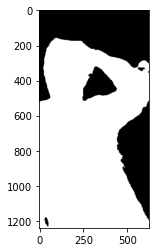

In [84]:
seg_map = np.all(output==seg_color, axis=-1) 
print(seg_map.shape) 
plt.imshow(seg_map, cmap='gray')
plt.show()

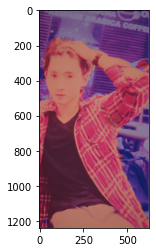

In [85]:
img_show = img_orig.copy()

img_mask = seg_map.astype(np.uint8) * 255

color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)

img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.4, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

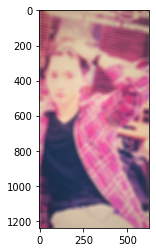

In [86]:
img_orig_blur = cv2.blur(img_orig, (25,25))

plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

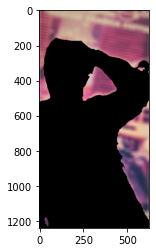

In [87]:
img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)

img_bg_mask = cv2.bitwise_not(img_mask_color)

img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

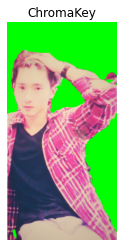

In [92]:
# 초록색 크로마키 배경 만들기
chroma_key_bg = np.zeros_like(img_orig)
chroma_key_bg[:] = [0, 255, 0]

# 마스크 값을 활용해서 배경을 초록색으로, 사람 영역은 원본 
img_chroma_key = np.where(img_mask_color == 255, img_orig, chroma_key_bg)

plt.imshow(cv2.cvtColor(img_chroma_key, cv2.COLOR_BGR2RGB))
plt.title("ChromaKey")
plt.axis('off')
plt.show()

### 문제점
* 모델은 PASCAL VOC 데이터셋으로 학습되어 있음. 약 20개의 라벨만 가지고 있기 때문에 일반화 성능이 저조할 것. 
    * 더 큰 데이터 셋으로 학습
* 해당 모델은 조명과 명암이 고르게 분포된 데이터로 학습. 어둡거나 과도하게 밝으면 위 실험처럼 성능저하가 발생함
    * 전처리를 통해 최대 효율을 뽑아내기
* 경계 정확도가 부정확함
    * 경계 보정을 위해 cv2.morphologyEx를 사용하여 팽창(Dilation)이나 침식(Erosion) 적용
* DeepLabv3 복잡한 구조와 많은 계산량 때문에 실시간 에플리케이션에 적합할지 의문
    * 경량화 or GPU

### 회고

* 블러링이라는 목표에서는 사실 엣지 부분의 정확도는 중요하지 않을 것이다.
* 해보니까 객체 탐지라는 관점에서는 바운딩박스가 상위 목표에 위치하기 때문에, 전처리,후처리(팽창or침식)가 크게 중요하지는 않을 것. 
* 오히려 모델 별로 성능 차이를 비교해보는 실험이 더 유용할 것 같다. 
* 해당 사항은 업데이트를 진행해볼 예정 
* [모델링크](paperswithcode.com)